In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn.functional as F
from sklearn import decomposition
from sklearn import manifold
import time
import random

# Helpers

## General

In [7]:
path_first_model = 'googLenet_cifar10.pth'
path_improved_model = 'googLenet_improved_cifar10.pth'

In [42]:
data_dir = '../CV_Data'
batch_size=128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def normalize_data(train_set,three_channels=False):
    print(train_set.data.shape)
    mean, std = train_set.data.mean(axis=(0,1,2))/255, train_set.data.std(axis=(0,1,2))/255
    print('Mean:', mean)
    print('Std: ', std)
    return transforms.Normalize(mean=tuple(mean),std=tuple(std))

In [11]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [12]:
def load_model(model, path):
  model.load_state_dict(torch.load(path))

## Dataset

In [13]:
def load_cifar(train_transforms, val_test_transforms):
    download = False
    if os.path.isdir(data_dir + '/' + 'cifar-10-batches-py') == False:
      download = True

    train_data = datasets.CIFAR10(root=data_dir, train=True, download=download, transform=train_transforms)
    test_data = datasets.CIFAR10(root=data_dir, train=False, download=download, transform=val_test_transforms)
    print("Training dataset:", train_data)
    print("Test dataset:", test_data)
    return train_data, test_data

In [14]:
def get_classes(dataset):
    return dataset.classes

In [15]:
def get_train_val_sets(train_data):
    train_set, val_set = torch.utils.data.random_split(train_data, [45000, 5000])
    return train_set, val_set

## Visualization

In [16]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

### Visualize images with classes

In [17]:
def visualize_images_from_dataset(dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = train_data[sample_idx]
        img = normalize_image(img)
        figure.add_subplot(rows, cols, i)
        plt.title(classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

In [18]:
def visualize_images_from_loader(loader):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    train_features, train_labels = next(iter(loader))

    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    for i in range(1,10):
      img = normalize_image(train_features[i].squeeze())
      label = classes[train_labels[i]]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

In [19]:
def get_10_sample_of_the_same_class(class_name, dataset):
    sample = []
    while len(sample) < 10:
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        if classes[label] == class_name:
            sample.append((img,label))
    return sample

In [20]:
def plot_sample_same_class(class_name, dataset):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    sample = get_10_sample_of_the_same_class(class_name, dataset)
    for i in range(1, cols * rows + 1):
        img, label = sample[i]
        img = normalize_image(img)
        figure.add_subplot(rows, cols, i)
        plt.title(classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

### Metrics

In [21]:
def plot_results(e, h, info, name):
    epochs_range = [i for i in range(e)]

    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize =(12,4))

    loss_plot.plot(epochs_range, h['train_loss'], color='red', label='train loss')
    loss_plot.plot(epochs_range, h['val_loss'], color='green', label='val loss')
    loss_plot.set_title('Epochs - Loss | {}'.format(info))
    loss_plot.legend()

    acc_plot.plot(epochs_range, h['train_acc'], color='red', label='train acc')
    acc_plot.plot(epochs_range, h['val_acc'], color='green', label='val acc')
    acc_plot.set_title('Epochs - Accuracy | {}'.format(info))
    acc_plot.legend()
    plt.savefig(name)
    plt.show()

In [22]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    conf_matrix = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(conf_matrix, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    return conf_matrix

In [23]:
def get_accuracy_for_specific_labels(class_label,conf_matrix):
  position_in_dict = np.argmax(conf_matrix[class_label])
  return np.sum(conf_matrix.diagonal()[position_in_dict]/np.sum(conf_matrix[position_in_dict]))

In [24]:
def show_per_class_accuracies():
    per_class_accuracies = []
    for idx,c in enumerate(classes):
        class_acc = get_accuracy_for_specific_labels(idx,cm)
        print(c + " class accuracy:", class_acc*100)
        per_class_accuracies.append((class_acc,idx))
    return per_class_accuracies

### Incorrect Examples

In [25]:
def get_incorrect_examples(cm, per_class_accuracies):
    five_top_incorrect_classes = sorted(per_class_accuracies, key=lambda acc: acc[0])[:5]
    img_labels_preds_idx = []
    for acc,idx in five_top_incorrect_classes:
        for i in [item for item in np.where(labels == idx)[0] if item not in np.where(pred_labels == idx)[0]]:
            img_labels_preds_idx.append((images[i],test_data.targets[i],pred_labels[i], idx))
    return img_labels_preds_idx     

In [26]:
def plot_incorrect_examples_from_top5_classes(n_images, confusion_matrix, per_class_accuracies, normalize=True):  
    fig = plt.figure(figsize = (16, 16))
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    incorrect_examples = get_incorrect_examples(confusion_matrix, per_class_accuracies)
    for i in range(rows*cols):
        sample_idx = random.randint(0, len(incorrect_examples))
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, false_label,idx = incorrect_examples[sample_idx]
        image = image.permute(1, 2, 0)
        true_class = classes[true_label]
        incorrect_class = classes[false_label]
        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy(),cmap="gray")
        ax.set_title(f'true label: {true_class} \n' \
                         f'pred label: {incorrect_class} ')
        ax.axis('off')

    fig.subplots_adjust(hspace = 0.4)

### PCA

In [27]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [28]:
def get_pca(data):
    pca = decomposition.PCA()
    pca.n_components = 2
    pca_data = pca.fit_transform(data)
    return pca_data

In [29]:
def plot_representations(data, labels, classes, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

## Training-Test Helpers

In [30]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        # compute output and loss
        output = model(data)
        loss = criterion(output, target)

        # backward and update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()

        train_correct += correct
        train_loss += loss.data.item()

        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data.item()))
    
    # Get training epoch loss and accuracy
    train_loss /= len(train_loader.dataset)
    epoch_acc = float(train_correct) / len(train_loader.dataset)
    print('\nOn Training set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
      train_loss, train_correct, len(train_loader.dataset),
      100.0 * epoch_acc))
    return train_loss, epoch_acc

In [31]:
def validate(val_loader, model, criterion):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
      for _, (data, target) in enumerate(val_loader):
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          loss += criterion(output, target).data.item()

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
      loss /= len(val_loader.dataset)
      epoch_acc = float(correct) / len(val_loader.dataset)
      print('On Val set Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
          loss, correct, len(val_loader.dataset),
          100.0 * epoch_acc))
    return loss,epoch_acc

In [32]:
def get_predictions(model, test_loader):
    model.eval()
    images = []
    labels = []
    probs = []
    correct = 0
    with torch.no_grad():
    
        for _, (data, target) in enumerate(test_loader):
          data = data.to(device)
          target = target.to(device)

          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

          images.append(data.cpu())
          labels.append(target.cpu())
          probs.append(pred.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    acc = float(correct) / len(test_loader.dataset)
    print('\nOn Test set Accuracy: {}/{} ({:.3f}%)\n'.format(
      correct, len(test_loader.dataset),
      100.0 * acc))
    return images, labels, probs

In [34]:
def fit_model(model, num_epochs, train_loader, val_loader, optimizer, criterion, lr_scheduler = None):

  best_acc = 0.0
  hist = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "per_epoch_time": [] }
  start_time = time.time()
  for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    if lr_scheduler != None:
      print("\nTrain Epoch {}: ".format(epoch))
      print("Current learning rate: {}".format(lr_scheduler.get_last_lr()))
    else:
      print("\nTrain Epoch {}: ".format(epoch))
      print("Learning rate: {}".format(optimizer.param_groups[0]['lr']))

    epoch_train_loss, epoch_train_acc = train(train_loader, model, criterion, optimizer, epoch)
    epoch_val_loss, epoch_val_acc = validate(val_loader, model, criterion)
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        print("New best Validation accuracy ({:.3f}%) achieved so far! \n".format(100.0 * best_acc))


    # Store acuracy and loss scores for current epoch
    hist['train_acc'].append(epoch_train_acc)
    hist['train_loss'].append(epoch_train_loss)
    hist['val_acc'].append(epoch_val_acc)
    hist['val_loss'].append(epoch_val_loss)

    if lr_scheduler != None:
      lr_scheduler.step()

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (epoch, epochs, per_epoch_ptime))
    hist["per_epoch_time"].append(per_epoch_ptime)
    
  training_time = time.time() - start_time
  print('\nModel fit in : {:.2f}s'.format(training_time))
  

  return model, hist

# GoogleNet - Original implemenation from Pytorch




In [49]:
googLeNet = torchvision.models.googlenet(pretrained=False, aux_logits=False)

In [50]:
print(f'The model has {count_parameters(googLeNet):,} trainable parameters')

The model has 6,624,904 trainable parameters


# CIFAR10

Since CIFAR10 classes are 10 and not 1000 like Image Net, the last dense layer needs to output 10 features instead of 1000

In [51]:
final_layer = nn.Linear(googLeNet.fc.in_features , 10)
googLeNet.fc = final_layer
googLeNet.to(device)
print('ready to train')

ready to train


In [52]:
train_transforms = transforms.Compose(
    [
      transforms.Resize(64), # resize images to 64 x 64
      transforms.ToTensor()
    ])

val_test_transforms = transforms.Compose(
    [
     transforms.Resize(64),
     transforms.ToTensor()
    ])

In [55]:
train_data, test_data = load_cifar(train_transforms, val_test_transforms)
transforms_normalize = normalize_data(train_data)

Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )
Test dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
           )
(50000, 32, 32, 3)
Mean: [0.49139968 0.48215841 0.44653091]
Std:  [0.24703223 0.24348513 0.26158784]


Based on the values per channel (mean,std) we want to normalize the data accordingly, therefore we reload the data with the appropriate transformation

In [56]:
train_transforms.transforms.insert(2, transforms_normalize)

The same is applied to the validation and test transformations

In [57]:
val_test_transforms.transforms.insert(2, transforms_normalize)

Reload the data with the normalization transformation

In [60]:
train_data, test_data = load_cifar(train_transforms, val_test_transforms)
classes = get_classes(test_data)

Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )
Test dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )


## Split into training 

In [61]:
train_set, val_set = get_train_val_sets(train_data)

The validation set needs to be transformed with the transfomer used for the test dataset

In [62]:
import copy
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = val_test_transforms

In [63]:
val_test_transforms.transforms

[Resize(size=64, interpolation=bilinear),
 ToTensor(),
 Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))]

Finally, the loaders can be created

In [64]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Initial Visualization

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000
Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


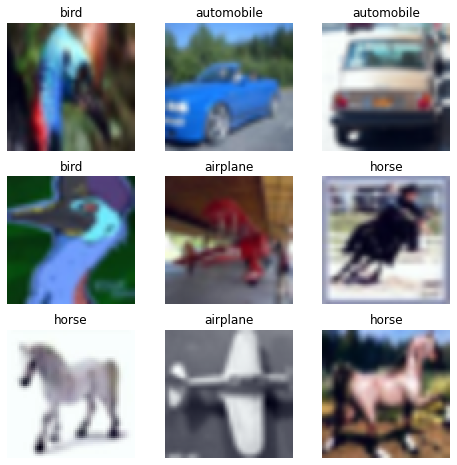

In [67]:
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(val_set)}')
print(f'Number of testing examples: {len(test_data)}')
visualize_images_from_loader(train_loader)

## Train googLeNet - original implemenation

In [ ]:
epochs = 50 
step_size = 5    
base_lr = 0.001    
# learning_rate_decay = 0.43

optimizer = torch.optim.SGD(googLeNet.parameters(), lr=base_lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,7,9], gamma=learning_rate_decay)

In [ ]:
googLeNet, hist = fit_model(
    model = googLeNet, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = loss_fn,
    lr_scheduler = None
  )


Train Epoch 1: 
Learning rate: 0.001
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.671580
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.533889
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.408836

On Training set Average loss: 0.0122, Accuracy: 19156/45000 (42.569%)
On Val set Average loss: 0.0098, Accuracy: 2785/5000 (55.700%)

New best Validation accuracy (55.700%) achieved so far! 

Epoch 1 of 50 with 32.34 s

Train Epoch 2: 
Learning rate: 0.001
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.270457
Train Epoch: 2 [25600/45000 (57%)]	Loss: 1.176559
Train Epoch: 2 [38400/45000 (85%)]	Loss: 1.067687

On Training set Average loss: 0.0085, Accuracy: 27446/45000 (60.991%)
On Val set Average loss: 0.0084, Accuracy: 3147/5000 (62.940%)

New best Validation accuracy (62.940%) achieved so far! 

Epoch 2 of 50 with 31.65 s

Train Epoch 3: 
Learning rate: 0.001
Train Epoch: 3 [12800/45000 (28%)]	Loss: 1.013366
Train Epoch: 3 [25600/45000 (57%)]	Loss: 0.639630
Train Epoch: 3 [38400/45000 (85%)]	Loss: 0.602

In [ ]:
save_model(googLeNet, path_first_model)

In [ ]:
images, labels, pred_labels = get_predictions(googLeNet, test_loader)


On Test set Accuracy: 8315/10000 (83.150%)



# Visualization after training

## Loss and Accuracy Plots

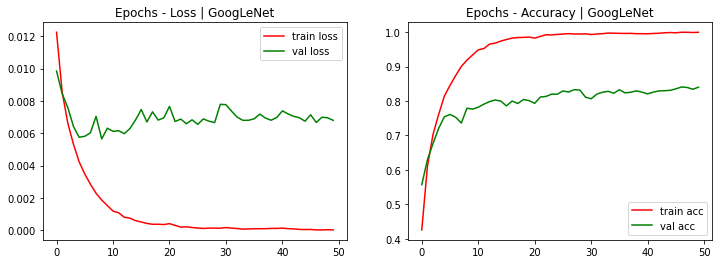

In [ ]:
plot_results(epochs, hist, info='GoogLeNet', name='googLeNet_cifar10.png')

In [ ]:
print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(hist['per_epoch_time']), epochs, 1626.43))

Avg per epoch ptime: 32.53, total 50 epochs ptime: 1033.31


## Confusion Matrix

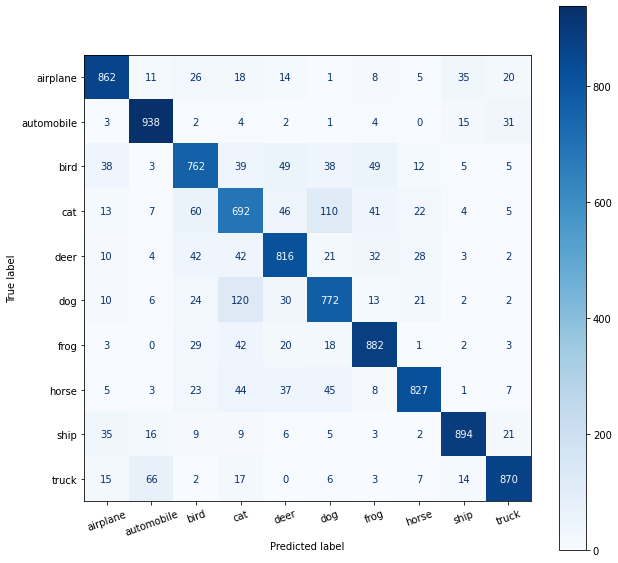

In [ ]:
cm = plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
per_class_accuracies = show_per_class_accuracies()

airplane class accuracy: 86.2
automobile class accuracy: 93.8
bird class accuracy: 76.2
cat class accuracy: 69.19999999999999
deer class accuracy: 81.6
dog class accuracy: 77.2
frog class accuracy: 88.2
horse class accuracy: 82.69999999999999
ship class accuracy: 89.4
truck class accuracy: 87.0


# Improvements

We visualize images belonging to the same class to apply the approriate transformations to the training dataset 

These transformations can improve the accuracy of the model as well as its generalization to new data

In [ ]:
for c in classes:
    plot_sample_same_class(c, train_data) # run to get a look at all classes

## Pytorch Transformations

After taking a look on the images for each classimport torchvision.transforms.functional as TF
import random

In [69]:
train_transforms = transforms.Compose(
    [
      transforms.Resize(64),
      transforms.RandomHorizontalFlip(0.5), # Horizontal Flip THe data
      transforms.RandomRotation(10), 
      transforms.RandomAffine(degrees=0, shear=10, translate=(0.1,0.1), scale=(0.8,1.2)), #
      transforms.ColorJitter(brightness=0.2,saturation=0.2, contrast=0.2),
      transforms.ToTensor(),
    transforms_normalize
    ])
val_test_transforms = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms_normalize
    ])

In [70]:
train_data, test_data = load_cifar(train_transforms, val_test_transforms)

Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../CV_Data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.8, 1.2), shear=[-10.0, 10.0])
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.49139967861519607, 0.48215840839460783, 0.44653091444546567), std=(0.24703223246328176, 0.24348512800005648, 0.26158784172796473))
           )
Test dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../CV_Data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               ToTensor()
  

In [71]:
train_set, val_set = get_train_val_sets(train_data)
val_set = copy.deepcopy(val_set)
val_set.dataset.transform = val_test_transforms

In [72]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

## Visualization of the Data after Augmentation

Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


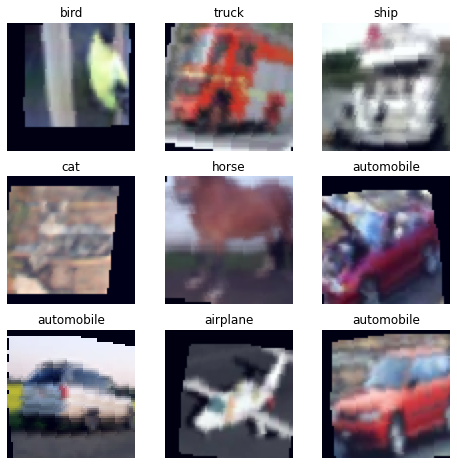

In [73]:
visualize_images_from_loader(train_loader)

## Model's Architecture

In [74]:
cfg = {
    'VGG_like': ['64unique', 64, 64]
}
def _vgg_like_conv(in_channels, list_layers):
  layers = []
  for x in list_layers:
      if x == 'M':
        layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)]
      else:
        if x == '64unique':
          x = int(x[0:2])
          layers += [nn.Conv2d(in_channels, x, stride=2, kernel_size=3, padding=3, bias=False),
                      nn.BatchNorm2d(x), # added batch normalizaiton layers
                    nn.ReLU(inplace=True)]


        else:
          layers += [nn.Conv2d(in_channels, x, kernel_size=(3,3), bias=False),
                    nn.BatchNorm2d(x), # added batch normalizaiton layers
                    nn.ReLU(inplace=True)]
      in_channels = x 
  return nn.Sequential(*layers)

In [77]:
googLeNet_imp = torchvision.models.googlenet(pretrained=False, aux_logits=False)
final_layer = nn.Linear(googLeNet_imp.fc.in_features , 10)
googLeNet_imp.fc = final_layer
googLeNet_imp.conv1 = _vgg_like_conv(3, cfg['VGG_like'])
googLeNet_imp.to(device)


GoogLeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [78]:
print(f'The model has {count_parameters(googLeNet_imp):,} trainable parameters')

The model has 5,676,458 trainable parameters


In [79]:
class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, smoothing: float = 0.1, 
                 reduction="mean", weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing   = smoothing
        self.reduction = reduction
        self.weight    = weight

    def reduce_loss(self, loss):
        return loss.mean() if self.reduction == 'mean' else loss.sum() \
         if self.reduction == 'sum' else loss

    def linear_combination(self, x, y):
        return self.smoothing * x + (1 - self.smoothing) * y

    def forward(self, preds, target):
        assert 0 <= self.smoothing < 1

        if self.weight is not None:
            self.weight = self.weight.to(preds.device)

        n = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        loss = self.reduce_loss(-log_preds.sum(dim=-1))
        nll = F.nll_loss(
            log_preds, target, reduction=self.reduction, weight=self.weight
        )
        return self.linear_combination(loss / n, nll)

In [58]:
epochs = 50   
base_lr = 0.01
learning_rate_decay = 0.1    

optimizer = torch.optim.SGD(googLeNet_imp.parameters(), lr=base_lr, momentum=0.9, weight_decay=4e-5)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = LabelSmoothingLoss(smoothing = 0.1, reduction="mean")

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,27,40,47], gamma=learning_rate_decay)

In [59]:
googLeNet_imp, hist = fit_model(
    model = googLeNet_imp, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = loss_fn,
    lr_scheduler = lr_scheduler
  )


Train Epoch 1: 
Current learning rate: [0.01]
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.858183
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.889845
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.783422

On Training set Average loss: 0.0148, Accuracy: 15385/45000 (34.189%)
On Val set Average loss: 0.0136, Accuracy: 2305/5000 (46.100%)

New best Validation accuracy (46.100%) achieved so far! 

Epoch 1 of 50 with 134.94 s

Train Epoch 2: 
Current learning rate: [0.01]
Train Epoch: 2 [12800/45000 (28%)]	Loss: 1.644203
Train Epoch: 2 [25600/45000 (57%)]	Loss: 1.568364
Train Epoch: 2 [38400/45000 (85%)]	Loss: 1.483873

On Training set Average loss: 0.0122, Accuracy: 23070/45000 (51.267%)
On Val set Average loss: 0.0118, Accuracy: 2851/5000 (57.020%)

New best Validation accuracy (57.020%) achieved so far! 

Epoch 2 of 50 with 134.01 s

Train Epoch 3: 
Current learning rate: [0.01]
Train Epoch: 3 [12800/45000 (28%)]	Loss: 1.284869
Train Epoch: 3 [25600/45000 (57%)]	Loss: 1.477408
Train Epoch: 3 [3

In [60]:
save_model(googLeNet_imp, path_improved_model)

In [61]:
images, labels, pred_labels = get_predictions(googLeNet_imp, test_loader)


On Test set Accuracy: 8585/10000 (85.850%)



## Visualization after training

In [62]:
classes = get_classes(test_data)

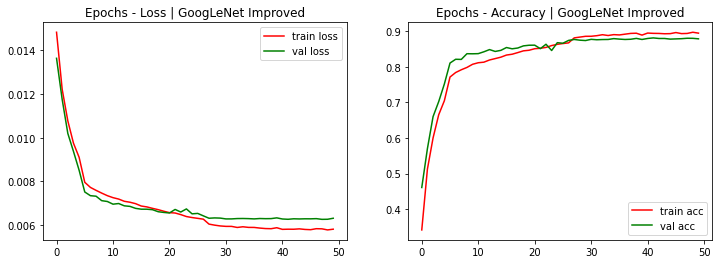

In [63]:
plot_results(epochs, hist, info='GoogLeNet Improved', name="googlenet_imp_cifar.png")

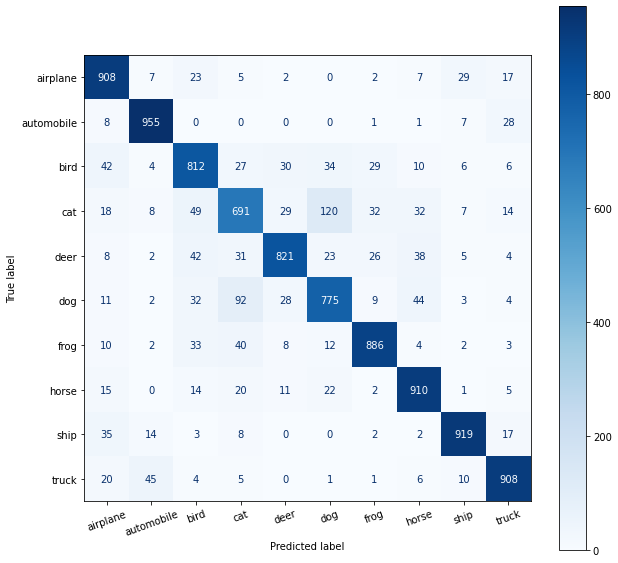

In [64]:
cm = plot_confusion_matrix(labels, pred_labels, classes)

In [65]:
per_class_accuracies = show_per_class_accuracies()

airplane class accuracy: 90.8
automobile class accuracy: 95.5
bird class accuracy: 81.2
cat class accuracy: 69.1
deer class accuracy: 82.1
dog class accuracy: 77.5
frog class accuracy: 88.6
horse class accuracy: 91.0
ship class accuracy: 91.9
truck class accuracy: 90.8


### PCA

In [67]:
outputs, labels = get_representations(googLeNet_imp, test_loader)

In [68]:
outputs[:1]

tensor([[-0.0594,  0.0947, -0.4558,  3.8799, -1.0154,  1.1957, -1.5040, -1.0051,
         -0.3845, -0.1638]])

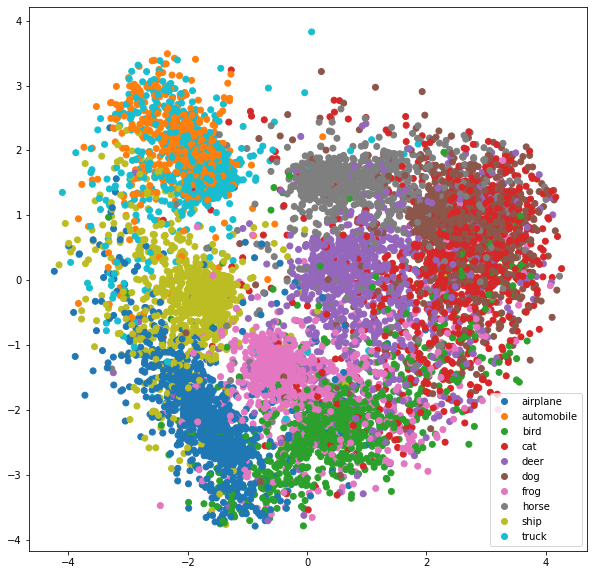

In [69]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)